# ELaboración de modelos de segmentación de imágenes

In [11]:
# libraries
from PIL import Image
from tqdm import tqdm
import numpy as np
import os
# model libraries
import warnings
from typing import TypeVar
import pandas as pd
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
import segmentation_models as sm
from segmentation_models import Unet, FPN, Linknet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [2]:
warnings.filterwarnings('ignore')
sm.set_framework('tf.keras')
sm.framework()

# typing
DataFrame = TypeVar('pandas.core.frame.DataFrame')

In [3]:
# Preprocessing

def rle2mask(rle, shape):
    """
        rle: run-length as string formatted (start length)
        shape: (height,width) of array to return
        Returns numpy array, 1 → mask, 0 → background
    """
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape).T


def save_masks(images: [str], masks: [str], src_dir: str, dst_dir: str):
    for index, image in tqdm(enumerate(images), total=len(images)):
        img = Image.open(src_dir + image)
        mask = rle2mask(masks[index], img.size[:2])
        img.save(f'{dst_dir}/{image}', mask)

    # change the images format and compress it


def compress(images: [str], src_dir: str, dst_dir: str, width: int, height: int):
    for index, image in tqdm(enumerate(images), total=len(images)):
        img = Image.open(src_dir + image)
        img = img.resize((width, height), Image.ANTIALIAS)
        name = os.path.basename(image).split('.')[0]
        img.save(f'{dst_dir}/{name}.png', quality=85, optimize=True)


# to convert the masks to images it is necessary to return also
# the mask test and train series
def get_train_test(filename: str):
    # separate the data into test and train
    data = pd.read_csv(filename)
    images = data[['id']]
    masks = data['rle']
    images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05,
                                                                          random_state=SEED)
    # adding the extension to the id images
    images_train['id'] = images_train['id'].apply(lambda x: str(x) + '.png')
    images_test['id'] = images_test['id'].apply(lambda x: str(x) + '.png')
    # reset the index
    images_train.reset_index(inplace=True, drop=True)
    images_test.reset_index(inplace=True, drop=True)
    masks_train.reset_index(inplace=True, drop=True)
    masks_test.reset_index(inplace=True, drop=True)
    return images_train, images_test


# Based on: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Data Augmentation
def augmentation(args: dict, data: DataFrame, path: str, size: int, x_col: str, batch: int, seed: int, subset: str):
    datagen = ImageDataGenerator(**args)
    generator = datagen.flow_from_dataframe(dataframe=data,
                                            directory=path,
                                            x_col=x_col,
                                            color_mode='rgb',
                                            class_mode=None,
                                            batch_size=batch,
                                            seed=seed,
                                            subset=subset)
    return generator


def test_preprocess(image):
    img = np.array(image)
    img = img / 255.
    img = np.expand_dims(img, 0)
    return img


def compare(segmentation_model, data: DataFrame, loop: int, treshold: float):
    fig, ax = plt.subplots(loop, 3, figsize=(25, 25))
    for x in range(loop):
        img = Image.open(IMAGES_PATH + data[x])
        img = test_preprocess(img)
        mask = Image.open(MASKS_PATH + data[x])
        prediction = segmentation_model.predict(img)
        prediction = (prediction > treshold).astype(np.uint8)
        ax[x][0].imshow(img[0, :, :, ])
        ax[x][1].imshow(mask, cmap='gray')
        ax[x][2].imshow(prediction[0, :, :, ], cmap='gray')


def history_plots(history, metrics=['iou_score', 'val_iou_score'], loss=['loss', 'val_loss']):
    train_metric = history.history[metrics[0]]
    val_metric = history.history[metrics[1]]
    train_loss = history.history[loss[0]]
    val_loss = history.history[loss[1]]

    epochs = range(1, len(train_metric) + 1)

    plt.plot(epochs, train_metric, label='Training score')
    plt.plot(epochs, val_metric, label='Validation Score')
    plt.title('Training and validation score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend(loc='best')

    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

In [4]:
# Constants
IMAGES_PATH = 'images/'
MASKS_PATH = 'masks/'
SEED = 197535
IMG_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 8
AUG_TRAIN_ARGS = dict(rescale=1. / 255,  # normalization
                      rotation_range=35,
                      horizontal_flip=True,
                      vertical_flip=True,
                      width_shift_range=0.05,
                      height_shift_range=0.05,
                      zoom_range=0.2,
                      fill_mode='nearest',
                      validation_split=0.13)

In [5]:
# get train and test
train, test = get_train_test('train.csv')

# train dataset
image_generator = augmentation(AUG_TRAIN_ARGS, train, IMAGES_PATH, IMG_SIZE, 'id', BATCH_SIZE, SEED, 'training')
mask_generator = augmentation(AUG_TRAIN_ARGS, train, MASKS_PATH, IMG_SIZE, 'id', BATCH_SIZE, SEED, 'training')
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
train_size = image_generator.samples

# validation
image_generator = augmentation(AUG_TRAIN_ARGS, train, IMAGES_PATH, IMG_SIZE, 'id', BATCH_SIZE, SEED, 'validation')
mask_generator = augmentation(AUG_TRAIN_ARGS, train, MASKS_PATH, IMG_SIZE, 'id', BATCH_SIZE, SEED, 'validation')
# combine generators into one which yields image and masks
validation_generator = zip(image_generator, mask_generator)
validation_size = image_generator.samples

Found 290 validated image filenames.
Found 290 validated image filenames.
Found 43 validated image filenames.
Found 43 validated image filenames.


# UNet Model

In [11]:
# creating a basic UNet model
from Unet import UNET

FACTORS = [1, 2, 4, 8, 16]
umodel = UNET(IMG_SIZE, 16, CHANNELS, FACTORS, 0.1)
model = umodel.model(optimizer='adam', loss='binary_crossentropy', metrics=[iou_score])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [12]:
# Callbacks
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    ModelCheckpoint('unet_model_v2.h5', verbose=1, save_best_only=True),
    TensorBoard(log_dir='/train')]

steps_per_epoch = train_size // BATCH_SIZE
steps_per_val = validation_size // BATCH_SIZE

results = model.fit(train_generator,
                    epochs=5,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=steps_per_val,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/5
14/14 [==============================] - ETA: 0s - loss: 0.3896 - iou_score: 0.0647
Epoch 00001: val_loss improved from inf to 0.31331, saving model to unet_model.h5
14/14 [==============================] - 119s 8s/step - loss: 0.3896 - iou_score: 0.0647 - val_loss: 0.3133 - val_iou_score: 0.0691
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.3094 - iou_score: 0.0582
Epoch 00002: val_loss improved from 0.31331 to 0.29188, saving model to unet_model.h5
14/14 [==============================] - 117s 8s/step - loss: 0.3094 - iou_score: 0.0582 - val_loss: 0.2919 - val_iou_score: 0.0640
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.3176 - iou_score: 0.0635
Epoch 00003: val_loss improved from 0.29188 to 0.28812, saving model to unet_model.h5
14/14 [==============================] - 118s 8s/step - loss: 0.3176 - iou_score: 0.0635 - val_loss: 0.2881 - val_iou_score: 0.0654
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0

# UNet model of Segmentetion Models library

In [13]:
BACKBONE = 'efficientnetb0'
preprocess_input = get_preprocessing(BACKBONE)

# define model
model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [13]:
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    ModelCheckpoint('unet_model_v2.h5', verbose=1, save_best_only=True),
    TensorBoard(log_dir='/train')]

steps_per_epoch = train_size // BATCH_SIZE
steps_per_val = validation_size // BATCH_SIZE

history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=steps_per_val,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.2355 - iou_score: 0.1811
Epoch 00001: val_loss improved from inf to 2.38904, saving model to unet_segment_model_2.0.h5
36/36 [==============================] - 234s 6s/step - loss: 1.2355 - iou_score: 0.1811 - val_loss: 2.3890 - val_iou_score: 0.1510
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.9148 - iou_score: 0.3000
Epoch 00002: val_loss did not improve from 2.38904
36/36 [==============================] - 211s 6s/step - loss: 0.9148 - iou_score: 0.3000 - val_loss: 3.1225 - val_iou_score: 0.1717
Epoch 3/10
31/36 [========================>.....] - ETA: 27s - loss: 0.8033 - iou_score: 0.3877

In [8]:
new_model = models.load_model('unet_segment_model_2.0.h5', compile=False)

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

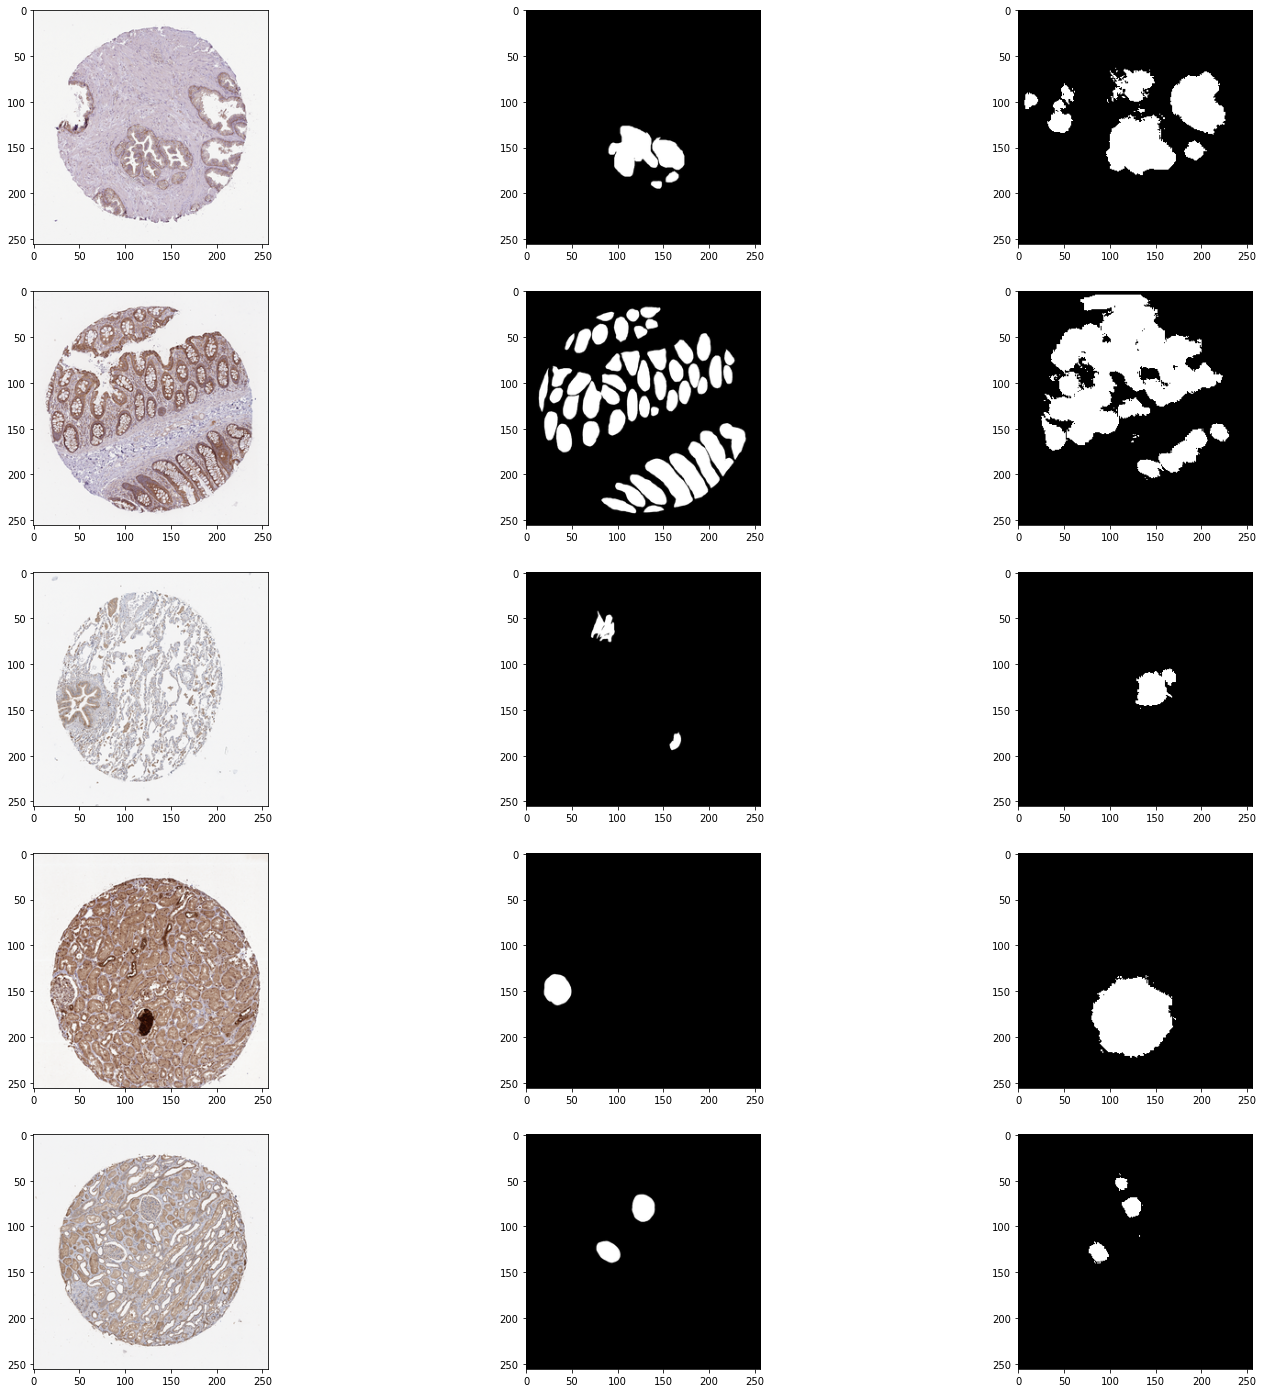

In [17]:
compare(new_model, test.id, 5, 0.9)

# Linknet model

In [12]:
BACKBONE = 'vgg16'
preprocess_input = get_preprocessing(BACKBONE)

# define model
model = Linknet(BACKBONE, encoder_weights='imagenet', classes=1)
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

In [13]:
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    ModelCheckpoint('unet_model_v2.h5', verbose=1, save_best_only=True),
    TensorBoard(log_dir='/train')]

steps_per_epoch = train_size // BATCH_SIZE
steps_per_val = validation_size // BATCH_SIZE

linknet_history = model.fit(train_generator,
                            epochs=10,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=validation_generator,
                            validation_steps=steps_per_val,
                            batch_size=BATCH_SIZE,
                            callbacks=callbacks,
                            verbose=1)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.3739 - iou_score: 0.1387 
Epoch 00001: val_loss improved from inf to 3.87156, saving model to linknet_segment_model_2.0.h5
36/36 [==============================] - 1314s 37s/step - loss: 1.3739 - iou_score: 0.1387 - val_loss: 3.8716 - val_iou_score: 0.1488
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 1.0929 - iou_score: 0.1830 
Epoch 00002: val_loss did not improve from 3.87156
36/36 [==============================] - 1841s 51s/step - loss: 1.0929 - iou_score: 0.1830 - val_loss: 4.5014 - val_iou_score: 0.1335
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 1.0243 - iou_score: 0.2279 
Epoch 00003: val_loss improved from 3.87156 to 3.49247, saving model to linknet_segment_model_2.0.h5
36/36 [==============================] - 1976s 54s/step - loss: 1.0243 - iou_score: 0.2279 - val_loss: 3.4925 - val_iou_score: 0.1350
Epoch 4/10
36/36 [==============================] - ETA: 0s -